# The JAX emulator: CIGALE prototype
In this notebook, I will prototype my idea for emulating radiative transfer codes with a Deepnet in order for it to be used inside xidplus. As `numpyro` uses JAX, the Deepnet wil ideally be trained with a JAX network. I will use CIGALE

### Advice from Kasia
Use the following modules:
* `Dale 2014` dust module with one parameter ($\alpha$) however, $\alpha$ can only take certian values in Cigale
    * 0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000
* `sfhdelayed` starforamtion history module. Has parameters $\tau$ (500-6500) ($age$ can be calculated from redshift). $f_{burst}$ is set to 0
* `bc03`stellar population synthesis module (don't change parameters)
* `dustatt_2powerlaws` 
    * set $Av_BC$ the V band attenuation in the birth clouds to between 0 - 4
    * set `BC_to_ISM_factor` to 0.7
    
Final parameters: $alpha$, $AV_BC$,$\tau$,$z$,$SFR$,$AGN$

Ideally, I would generate values from prior. I can do that for $AV_BC$,$\tau$,$z$,$SFR$,$AGN$ but not $\alpha$ given that there are fixed values.

In [1]:

from astropy.cosmology import WMAP9 as cosmo
import jax
import numpy as onp
import pylab as plt
import astropy.units as u
import scipy.integrate as integrate
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 
import matplotlib.pyplot as plt # visualization
# Generate key which is used to generate random numbers
key = random.PRNGKey(2)
from xidplus import cigale

W0117 13:51:39.512974 4613914048 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
W0117 13:51:41.490610 4613914048 logger.py:204] AstropyDeprecationWarning: block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [2]:
onp.random.seed(2)

### Generate CIGALE SEDs

In [3]:
from astropy.io import fits
from astropy.table import Table
import scipy.stats as stats

In [4]:
alpha=onp.array([0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000])
alpha_rv = stats.randint(0, len(alpha))
av_bc_rv=stats.uniform(0.1,4.0)
tau_rv=stats.randint(500,6500)
z_rv=stats.uniform(0.01,6)
sfr_rv=stats.loguniform(0.01,30000)
agn_frac_rv=stats.beta(1,3)

In [5]:
from astropy.cosmology import Planck13

In [6]:
z=z_rv.rvs(1)[0]
onp.int(Planck13.age(z).value*1000)
alpha[alpha_rv.rvs(1)[0]]

2.875

In [7]:
nsamp=1
from astropy.constants import L_sun, M_sun
from astropy.table import vstack
col_scale=['spire_250','spire_350','spire_500','dust.luminosity','sfh.sfr','stellar.m_star']
parameter_names=onp.array(['tau_main','age_main','Av_BC','alpha','fracAGN','redshift'])
all_SEDs=[]
for i in range(0,nsamp):
    z=z_rv.rvs(1)[0]
    
    parameters={'tau_main':[tau_rv.rvs(1)[0]],'age_main':[onp.int(Planck13.age(z).value*1000)],
                'Av_BC':[av_bc_rv.rvs(1)[0]],'alpha':[alpha[alpha_rv.rvs(1)[0]]],'fracAGN':[agn_frac_rv.rvs(1)[0]],'redshift':[z]}
    path_to_cigale='/Volumes/pdh_storage/cigale/'
    path_to_ini_file='pcigale_kasia_nn.ini'
    SEDs=cigale.generate_SEDs(parameter_names, parameters, path_to_cigale, path_to_ini_file, filename = 'tmp_single')
    #set more appropriate units for dust

    SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
    scale=1.0/SEDs['sfh.sfr']
    for c in col_scale:
        SEDs[c]=SEDs[c]*scale*sfr_rv.rvs(1)[0]
    all_SEDs.append(SEDs)
    if i and i % 100 == 0:
        tmp_SEDs=vstack(all_SEDs)
        tmp_SEDs.write('kasia_gen_SEDs_{}.fits'.format(i),overwrite=True)
        all_SEDs=[]

---


In [9]:
all_SEDs[0]

id,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.tau_main,universe.redshift
,mJy,mJy,mJy,W,solMass / yr,solMass,,mag,,Myr,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.0022648338953013686,0.6101981528070004,0.13285984543787135,486811658.0261648,21.20839313475317,71919897.44752046,0.100848769635,2.038996387135,0.5,3014.0,5.5992451949267


### Generate values for CIGALE

Redshift

In [3]:
onp.array2string(10.0**np.arange(-2.5,0.77,0.1), separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

'[0.0032,0.0040,0.0050,0.0063,0.0079,0.0100,0.0126,0.0158,0.0200,0.0251, 0.0316,0.0398,0.0501,0.0631,0.0794,0.1000,0.1259,0.1585,0.1995,0.2512, 0.3162,0.3981,0.5012,0.6310,0.7943,1.0000,1.2589,1.5849,1.9953,2.5119, 3.1623,3.9810,5.0118]'

In [5]:
onp.array2string(np.arange(0.1,4,0.3),separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

'[0.1000,0.4000,0.7000,1.0000,1.3000,1.6000,1.9000,2.2000,2.5000,2.8000, 3.1000,3.4000,3.7000]'

AGN frac

In [4]:
onp.array2string(np.arange(0.001,1,0.075),separator=',',formatter={'float_kind':lambda x: "%.3f" % x}).replace('\n','')

'[0.001,0.076,0.151,0.226,0.301,0.376,0.451,0.526,0.601,0.676,0.751,0.826, 0.901,0.976]'

In [14]:
SEDs=Table.read('/Volumes/pdh_storage/cigale/out/models-block-0.fits')
#set more appropriate units for dust
from astropy.constants import L_sun, M_sun
SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value


In [15]:
SEDs=SEDs[onp.isfinite(SEDs['spire_250'])]

In [16]:
SEDs

id,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.tau_main,universe.redshift
,mJy,mJy,mJy,W,solMass / yr,solMass,,mag,,Myr,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,6.664787981156792e-09,2.579075857126304e-09,9.154350728346564e-10,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.0032
1,4.272567065611162e-09,1.6536408901353577e-09,5.87030971959381e-10,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.004
2,2.7401305723303493e-09,1.0607611243982099e-09,3.766230281788533e-10,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.005
3,1.7306250478806803e-09,6.701473917718022e-10,2.379845841843187e-10,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.0063
4,1.1042574710404118e-09,4.277475805942584e-10,1.5194164617231545e-10,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.0079
5,6.921688128956865e-10,2.682413523259305e-10,9.531300799051766e-11,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.01
6,4.383324492387039e-10,1.6996450724863183e-10,6.041772738676337e-11,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.0126
7,2.8060358442643693e-10,1.0887903487586143e-10,3.872338294196482e-11,0.038722519393397305,9.100896611075192e-13,0.7106245236562091,0.001,0.1,0.0625,500.0,0.0158


In [8]:
from astropy.table import vstack

In [24]:
(1.0/dataset['sfh.sfr'])*dataset['sfh.sfr']*10.0**scale_table

DeviceArray([1.0000000e+08, 1.0000000e+08, 1.0000000e+08, ...,
             5.6234133e+13, 5.6234133e+13, 5.6234133e+13], dtype=float32)

In [25]:
# define a range of scales
scale=np.arange(8,14,0.25)
#repeat the SED table by the number of scale steps
dataset=vstack([SEDs for i in range(0,scale.size)])
#repeat the scale range by the number of entries in table (so I can easily multiply each column)
scale_table=np.repeat(scale,len(SEDs))
#parameters to scale
col_scale=['spire_250','spire_350','spire_500','dust.luminosity','sfh.sfr','stellar.m_star']
for c in col_scale:
    dataset[c]=dataset[c]*10.0**scale_table
dataset['log10_sfh.sfr']=onp.log10(dataset['sfh.sfr'])
dataset['log10_universe.redshift']=onp.log10(dataset['universe.redshift'])
# transform AGN fraction to logit scale
dataset['logit_agnfrac']=onp.log(dataset['agn.fracAGN']/(1-dataset['agn.fracAGN']))
#shuffle dataset
dataset=dataset[onp.random.choice(len(dataset), len(dataset), replace=False)]

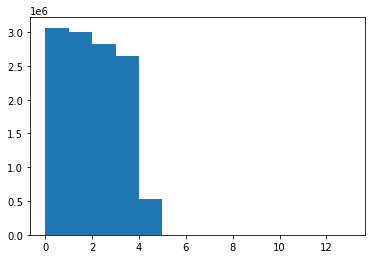

In [26]:
plt.hist(dataset['log10_sfh.sfr'],bins=(np.arange(0,14)));


In [27]:
dataset

id,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.tau_main,universe.redshift,log10_sfh.sfr,log10_universe.redshift,logit_agnfrac
,,,,,,,,mag,,Myr,,,,
int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float64,float64
490252,1160.6235,483.27942,163.47063,6990731300.0,0.740176,2342796500.0,0.151,3.1,1.8125,3500.0,0.0079,-0.13066499,-2.1023729087095586,-1.726779349496423
428429,0.006685692,0.0031328278,0.0012310973,370134140.0,0.037604094,131436680.0,0.301,3.7,1.0625,3000.0,0.631,-1.4247649,-0.19997064075586568,-0.8425404774849347
652959,31.126167,20.64707,9.253553,128308100000.0,49.521706,132313310000.0,0.301,0.1,3.0625,5000.0,0.3981,1.6947956,-0.40000782241590205,-0.8425404774849347
442192,0.079513066,0.0880193,0.057997216,2390347000.0,0.41623157,1317451300.0,0.076,0.4,3.0625,3500.0,1.0,-0.38066497,0.0,-2.497978731355353
731545,3343.0225,1588.2834,559.03064,1607026000.0,0.2885123,744739500.0,0.451,0.4,3.8125,5500.0,0.004,-0.5398357,-2.3979400086720375,-0.19663110200685208
297069,64940.26,29118.043,10031.254,109114300000.0,18.232462,73675686000.0,0.001,0.4,2.4375,2500.0,0.0063,1.2608453,-2.2006594505464183,-6.906754778648554
651641,15.117687,10.061898,4.695546,228167660000.0,88.06343,235290030000.0,0.451,0.1,2.0625,5000.0,0.631,1.9447956,-0.19997064075586568,-0.19663110200685208
422446,1345.552,524.6432,184.69086,2069125900000.0,211.46336,739122800000.0,0.376,3.4,0.8125,3000.0,0.0631,2.3252351,-1.1999706407558657,-0.5065612249795332


## DeepNet building
I will build a multi input, multi output deepnet model as my emulator, with parameters as input and the observed flux as outputs. I will train on log10 flux to make the model easier to train, and have already standarised the input parameters. I wilkl be using `stax` which can be thought of as the `Keras` equivalent for `JAX`. This [blog](https://blog.evjang.com/2019/02/maml-jax.html) was useful starting point.

I will use batches to help train the network

In [38]:
dataset=dataset[0:18000000]

In [40]:
len(dataset)/1200

15000.0

In [41]:
split=0.75
inner_batch_size=1200

train_ind=onp.round(0.75*len(dataset)).astype(int)
train=dataset[0:train_ind]
validation=dataset[train_ind:]
input_cols=['log10_sfh.sfr','agn.fracAGN','universe.redshift', 'attenuation.Av_BC','dust.alpha','sfh.tau_main']
output_cols=['spire_250','spire_350','spire_500']
train_batch_X=np.asarray([i.data for i in train[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
train_batch_Y=np.asarray([np.log(i.data) for i in train[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_X=np.asarray([i.data for i in validation[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_Y=np.asarray([np.log(i.data) for i in validation[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)

In [42]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(128), LeakyRelu,
    Dense(128), LeakyRelu,
    Dense(128), LeakyRelu,
    Dense(128), Relu,
    Dense(len(output_cols))
)
in_shape = (-1, len(input_cols),)
out_shape, net_params = net_init(key,in_shape)

In [43]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

In [ ]:
opt_init, opt_update, get_params= optimizers.adam(step_size=5e-4)
out_shape, net_params = net_init(key,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp

np_batched_loss_1 = []
valid_loss=[]
for i in range(10000):
    opt_state, l = step(i, opt_state, train_batch_X, train_batch_Y)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,validation_batch_X,validation_batch_Y))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

0


In [ ]:
for i in range(2000):
    opt_state, l = step(i, opt_state, train_batch_X, train_batch_Y)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,validation_batch_X,validation_batch_Y))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

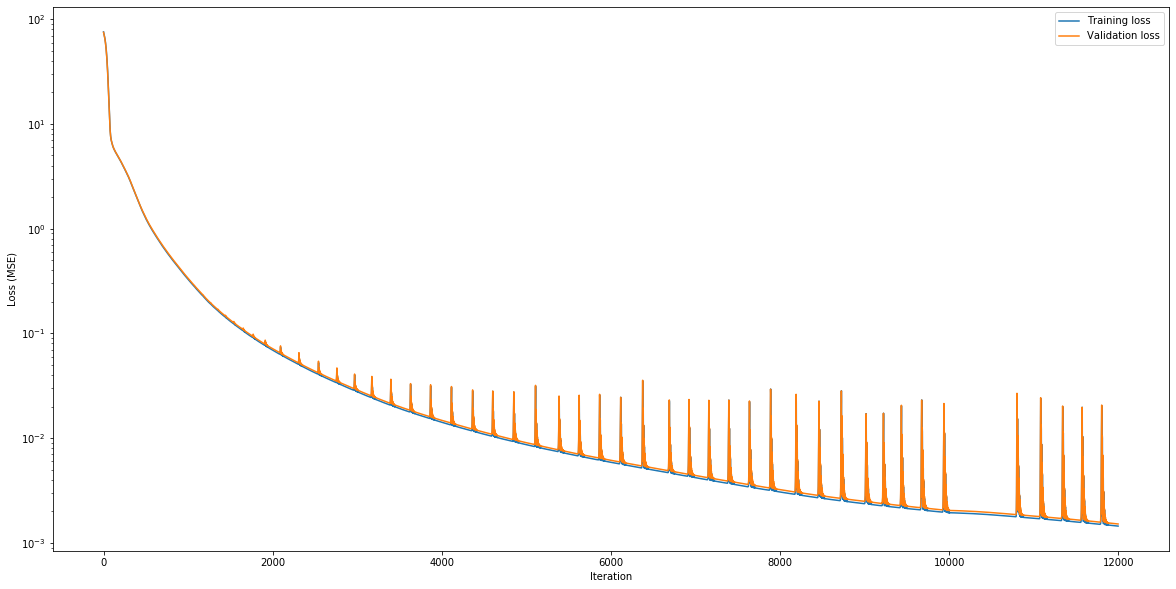

In [52]:
plt.figure(figsize=(20,10))
plt.semilogy(np_batched_loss_1,label='Training loss')
plt.semilogy(valid_loss,label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.legend()


## Investigate performance of each band of emulator
To visulise performance of the trainied emulator, I will show the difference between real and emulated for each band.

In [53]:
net_params = get_params(opt_state)
predictions = net_apply(net_params,validation_batch_X)

In [54]:
validation_batch_X.shape

(41, 1200, 3)

In [55]:
validation_batch_X[0,:,:].shape

(1200, 3)

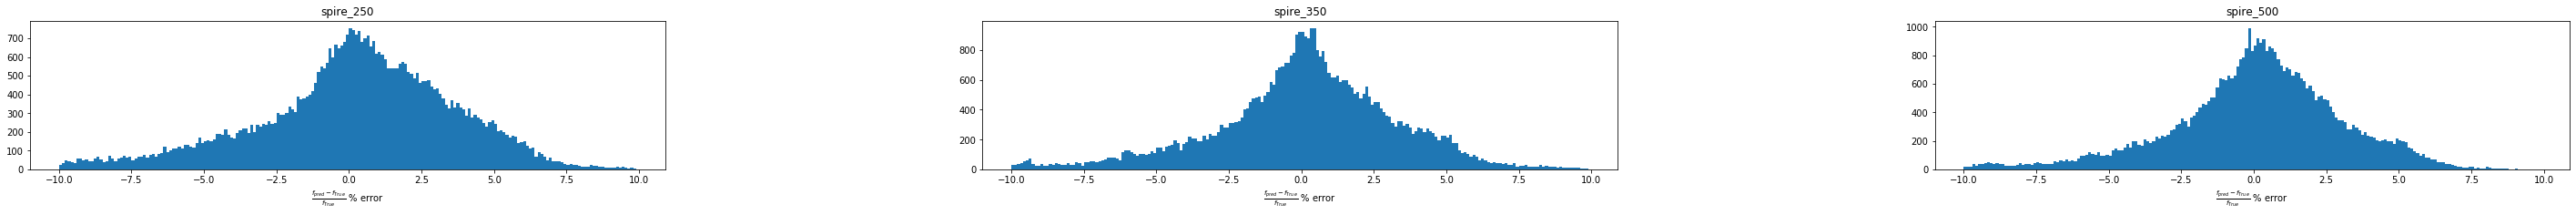

In [56]:
res=((np.exp(predictions)-np.exp(validation_batch_Y))/(np.exp(validation_batch_Y)))
fig,axes=plt.subplots(1,len(output_cols),figsize=(50,len(output_cols)))
for i in range(0,len(output_cols)):
    axes[i].hist(res[:,:,i].flatten()*100.0,np.arange(-10,10,0.1))
    axes[i].set_title(output_cols[i])
    axes[i].set_xlabel(r'$\frac{f_{pred} - f_{True}}{f_{True}} \ \%$ error')
plt.subplots_adjust(wspace=0.5)

## Save network
Having trained and validated network, I need to save the network and relevant functions

In [57]:
import cloudpickle


In [58]:
with open('CIGALE_emulator_20210330_log10sfr_uniformAGN_z.pkl', 'wb') as f:
    cloudpickle.dump({'net_init':net_init,'net_apply': net_apply,'params':net_params}, f)
    
net_init, net_apply

(<function jax.experimental.stax.serial.<locals>.init_fun(rng, input_shape)>,
 <function jax.experimental.stax.serial.<locals>.apply_fun(params, inputs, **kwargs)>)

## Does SED look right?

In [59]:
wave=np.array([250,350,500])

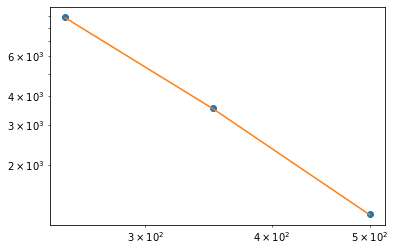

In [63]:
plt.loglog(wave,np.exp(net_apply(net_params,np.array([2.95, 0.801, 0.1]))),'o')
#plt.loglog(wave,10.0**net_apply(net_params,np.array([3.0,0.0,0.0])),'o')
plt.loglog(wave,dataset[(dataset['universe.redshift']==0.1) & (dataset['agn.fracAGN'] == 0.801) & (dataset['sfh.sfr']>900) & (dataset['sfh.sfr']<1100)][output_cols].values())

In [65]:
dataset[(dataset['universe.redshift']==0.1) & (dataset['agn.fracAGN'] == 0.801) & (dataset['sfh.sfr']>900) & (dataset['sfh.sfr']<1100)]

id,IRAC1,megacam_g,megacam_i,megacam_r,megacam_u,megacam_y,megacam_z,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.BC_to_ISM_factor,attenuation.bessell_b,attenuation.galex_fuv,attenuation.slope_BC,attenuation.slope_ISM,dust.qpah,dust.umin,sfh.age,sfh.burst_age,sfh.f_burst,sfh.tau_main,universe.redshift,log10_sfh.sfr,log10_universe.redshift,logit_agnfrac
,,,,,,,,,,,,,,,,,,mag,mag,mag,,,,Myr,,,,,,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
2699,3561.7131,0.81075984,2.373399,1.5528784,0.25492316,2.4790812,3.5117917,12396.599,8839.021,3535.3625,1214.4366,8037312500000.0,4314639400.0,904.5928,175056060000.0,0.801,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.1,2.956453,-1.0,1.3925561223438672


In [1]:
import xidplus

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from xidplus.numpyro_fit.misc import load_emulator

In [4]:
obj=load_emulator('CIGALE_emulator_20210330_log10sfr_uniformAGN_z.pkl')

In [6]:
type(obj['params'])

list

In [7]:
import json

In [9]:
import numpy as np

In [35]:
np.savez('CIGALE_emulator_20210610_kasia',obj['params'],allow_pickle=True)

In [34]:
ls

CIGALE_emulator_20210303.pkl
CIGALE_emulator_20210305.pkl
CIGALE_emulator_20210310_log10sfr_uniformAGN_log10z.pkl
CIGALE_emulator_20210311_log10sfr_uniformAGN_log10z_irac1.pkl
CIGALE_emulator_20210315_log10sfr_uniformAGN_log10z_irac1_megacam.pkl
CIGALE_emulator_20210329_log10sfr_uniformAGN_z_log_irac1_megacam.pkl
CIGALE_emulator_20210330_log10sfr_uniformAGN_z.pkl
CIGALE_emulator_20210420_log10sfr_uniformAGN_z.pkl.npz
GB_emulator_20210106.pkl
GB_emulator_20210209.pkl
GB_emulator_20210323.pkl
GB_emulator_20210324_notlog10z_T.pkl
Greybody_emulator.ipynb
JAX_CIGALE_emulator.ipynb
JAX_greybody_emulator.ipynb
Prior_pred_fits_0.pkl
Prior_pred_fits_1.pkl
Prior_pred_fits_2.pkl
Prior_pred_fits_3.pkl
Prior_pred_fits_4.pkl
Prior_pred_fits_5.pkl
Prior_pred_fits_6.pkl
Prior_pred_fits_7.pkl
Prior_pred_fits_8.pkl
Prior_pred_fits_9.pkl
XID+SED_Model_Building.ipynb
XID+SED_Principled_Workflow-VI.ipynb
XID+SED_Principled_Workflow.ipynb
XID+example_run_script-Prior_predictive_checks.ipynb
XID+posterior_an

In [25]:
x=np.load('params_save.npz',allow_pickle=True)

In [30]:
x['arr_0'].tolist()

[(array([[ 1.53069824e-01, -2.10883975e-01,  2.01293573e-01,
           2.00886243e-05,  8.39339555e-05, -1.59104392e-01,
          -3.11721444e-01,  8.15778226e-02, -1.30519122e-01,
           2.66870164e-04,  2.02755541e-01,  2.00401381e-01,
           2.55665570e-01,  9.49345157e-03, -2.87445990e-04,
           2.97707498e-01,  2.03495666e-01,  6.32490441e-02,
           1.99170873e-01,  1.80119430e-04,  1.20747246e-01,
          -1.67233795e-01, -2.98334770e-02, -3.50672485e-06,
           1.22021355e-01,  1.01019315e-01,  1.96768597e-01,
          -1.26161918e-01,  3.03663150e-03,  2.84228637e-03,
           1.29882827e-01, -7.99915791e-02, -1.29280478e-01,
           4.20932584e-02, -8.54701623e-02,  5.27626090e-02,
          -1.17510051e-01,  1.01156078e-01,  4.60322537e-02,
           8.14467445e-02,  5.08916415e-02,  1.00427233e-01,
           9.20651853e-03,  4.08653691e-02, -4.04455874e-04,
          -8.63167420e-02, -1.63388662e-02, -6.32612929e-02,
          -4.41273190e-0

In [31]:
obj['params']

[(array([[ 1.53069824e-01, -2.10883975e-01,  2.01293573e-01,
           2.00886243e-05,  8.39339555e-05, -1.59104392e-01,
          -3.11721444e-01,  8.15778226e-02, -1.30519122e-01,
           2.66870164e-04,  2.02755541e-01,  2.00401381e-01,
           2.55665570e-01,  9.49345157e-03, -2.87445990e-04,
           2.97707498e-01,  2.03495666e-01,  6.32490441e-02,
           1.99170873e-01,  1.80119430e-04,  1.20747246e-01,
          -1.67233795e-01, -2.98334770e-02, -3.50672485e-06,
           1.22021355e-01,  1.01019315e-01,  1.96768597e-01,
          -1.26161918e-01,  3.03663150e-03,  2.84228637e-03,
           1.29882827e-01, -7.99915791e-02, -1.29280478e-01,
           4.20932584e-02, -8.54701623e-02,  5.27626090e-02,
          -1.17510051e-01,  1.01156078e-01,  4.60322537e-02,
           8.14467445e-02,  5.08916415e-02,  1.00427233e-01,
           9.20651853e-03,  4.08653691e-02, -4.04455874e-04,
          -8.63167420e-02, -1.63388662e-02, -6.32612929e-02,
          -4.41273190e-0